In [0]:
pip install chart-studio


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
tf.random.set_seed(1)
from numpy.random import seed
np.random.seed(1)      # NumPy seed


In [0]:
# Example for reading the CSV after upload
test = spark.read.csv('/FileStore/tables/test.csv', header=True).toPandas()
train = spark.read.csv('/FileStore/tables/train.csv', header=True).toPandas()

In [0]:

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
lag_size = (test['date'].max() - train['date'].max()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)


Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [0]:
train = train[(train['date'] >= '2017-01-01')]  #Sub-sample train set to get only the last year of data and reduce training time¶
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


In [0]:
type(train_gp)

pandas.core.frame.DataFrame

In [0]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
window = 29
lag_size = 1
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26),item(t-25),store(t-25),sales(t-25),item(t-24),store(t-24),sales(t-24),item(t-23),store(t-23),sales(t-23),item(t-22),store(t-22),sales(t-22),item(t-21),store(t-21),sales(t-21),item(t-20),store(t-20),sales(t-20),item(t-19),store(t-19),sales(t-19),item(t-18),store(t-18),sales(t-18),item(t-17),store(t-17),sales(t-17),item(t-16),...,sales(t-12),item(t-11),store(t-11),sales(t-11),item(t-10),store(t-10),sales(t-10),item(t-9),store(t-9),sales(t-9),item(t-8),store(t-8),sales(t-8),item(t-7),store(t-7),sales(t-7),item(t-6),store(t-6),sales(t-6),item(t-5),store(t-5),sales(t-5),item(t-4),store(t-4),sales(t-4),item(t-3),store(t-3),sales(t-3),item(t-2),store(t-2),sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+1),store(t+1),sales(t+1)
29,1,1,19.0,1,1,15.0,1,1,10.0,1,1,16.0,1,1,14.0,1,1,24.0,1,1,14.0,1,1,20.0,1,1,18.0,1,1,11.0,1,1,14.0,1,1,17.0,1,1,7.0,1,...,10.0,1,1,16.0,1,1,22.0,1,1,13.0,1,1,21.0,1,1,9.0,1,1,18.0,1,1,14.0,1,1,13.0,1,1,10.0,1,1,16.0,1,1,24.0,1,1,9.0,1,1,17.0
30,1,1,15.0,1,1,10.0,1,1,16.0,1,1,14.0,1,1,24.0,1,1,14.0,1,1,20.0,1,1,18.0,1,1,11.0,1,1,14.0,1,1,17.0,1,1,7.0,1,1,16.0,1,...,16.0,1,1,22.0,1,1,13.0,1,1,21.0,1,1,9.0,1,1,18.0,1,1,14.0,1,1,13.0,1,1,10.0,1,1,16.0,1,1,24.0,1,1,9.0,1,1,17.0,1,1,15.0
31,1,1,10.0,1,1,16.0,1,1,14.0,1,1,24.0,1,1,14.0,1,1,20.0,1,1,18.0,1,1,11.0,1,1,14.0,1,1,17.0,1,1,7.0,1,1,16.0,1,1,29.0,1,...,22.0,1,1,13.0,1,1,21.0,1,1,9.0,1,1,18.0,1,1,14.0,1,1,13.0,1,1,10.0,1,1,16.0,1,1,24.0,1,1,9.0,1,1,17.0,1,1,15.0,1,1,17.0
32,1,1,16.0,1,1,14.0,1,1,24.0,1,1,14.0,1,1,20.0,1,1,18.0,1,1,11.0,1,1,14.0,1,1,17.0,1,1,7.0,1,1,16.0,1,1,29.0,1,1,15.0,1,...,13.0,1,1,21.0,1,1,9.0,1,1,18.0,1,1,14.0,1,1,13.0,1,1,10.0,1,1,16.0,1,1,24.0,1,1,9.0,1,1,17.0,1,1,15.0,1,1,17.0,1,1,24.0
33,1,1,14.0,1,1,24.0,1,1,14.0,1,1,20.0,1,1,18.0,1,1,11.0,1,1,14.0,1,1,17.0,1,1,7.0,1,1,16.0,1,1,29.0,1,1,15.0,1,1,14.0,1,...,21.0,1,1,9.0,1,1,18.0,1,1,14.0,1,1,13.0,1,1,10.0,1,1,16.0,1,1,24.0,1,1,9.0,1,1,17.0,1,1,15.0,1,1,17.0,1,1,24.0,1,1,25.0


In [0]:
type(series)

pandas.core.frame.DataFrame

In [0]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [0]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [0]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (134399, 30)
Validation set shape (33600, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
111481,18.0,26.0,21.0,23.0,44.0,26.0,43.0,22.0,24.0,28.0,23.0,35.0,36.0,31.0,26.0,38.0,22.0,18.0,36.0,33.0,39.0,23.0,32.0,31.0,23.0,34.0,32.0,35.0,22.0,27.0
1169,19.0,19.0,19.0,22.0,20.0,18.0,19.0,22.0,17.0,24.0,27.0,26.0,18.0,17.0,19.0,14.0,27.0,27.0,25.0,21.0,28.0,25.0,21.0,23.0,40.0,33.0,26.0,22.0,27.0,25.0
120896,20.0,25.0,24.0,25.0,25.0,22.0,15.0,22.0,24.0,27.0,25.0,22.0,20.0,26.0,33.0,23.0,20.0,29.0,32.0,24.0,21.0,24.0,30.0,20.0,27.0,28.0,22.0,35.0,28.0,19.0
148769,51.0,55.0,60.0,70.0,56.0,46.0,54.0,53.0,56.0,79.0,61.0,66.0,48.0,41.0,48.0,70.0,59.0,61.0,66.0,46.0,48.0,58.0,42.0,52.0,68.0,65.0,59.0,49.0,50.0,50.0
43730,98.0,58.0,57.0,85.0,68.0,77.0,93.0,65.0,62.0,71.0,55.0,69.0,80.0,89.0,72.0,43.0,62.0,80.0,69.0,71.0,68.0,83.0,60.0,68.0,73.0,71.0,74.0,77.0,90.0,50.0


In [0]:
type(X_train)

pandas.core.frame.DataFrame

In [0]:
epochs = 30
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [0]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (134399, 30, 1)
Validation set shape (33600, 30, 1)


In [0]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [0]:
from keras.optimizers import Adam

# Recreate the optimizer
adam = Adam()

# Compile the model with the new optimizer
model_lstm.compile(loss='mse', optimizer=adam)


In [0]:
lstm_history = model_lstm.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=25, verbose=2)

Epoch 1/25
4200/4200 - 44s - 10ms/step - loss: 172.6852 - val_loss: 118.3244
Epoch 2/25
4200/4200 - 79s - 19ms/step - loss: 105.3273 - val_loss: 88.8977
Epoch 3/25
4200/4200 - 43s - 10ms/step - loss: 511.4693 - val_loss: 105.1618
Epoch 4/25
4200/4200 - 42s - 10ms/step - loss: 105.8605 - val_loss: 94.6980
Epoch 5/25
4200/4200 - 80s - 19ms/step - loss: 98.7541 - val_loss: 104.1860
Epoch 6/25
4200/4200 - 42s - 10ms/step - loss: 96.0401 - val_loss: 93.2247
Epoch 7/25
4200/4200 - 40s - 10ms/step - loss: 167.7878 - val_loss: 145.2987
Epoch 8/25
4200/4200 - 41s - 10ms/step - loss: 122.6720 - val_loss: 99.0915
Epoch 9/25
4200/4200 - 41s - 10ms/step - loss: 102.4880 - val_loss: 92.2127
Epoch 10/25
4200/4200 - 82s - 20ms/step - loss: 97.4066 - val_loss: 92.9012
Epoch 11/25
4200/4200 - 82s - 19ms/step - loss: 111.6281 - val_loss: 95.0433
Epoch 12/25
4200/4200 - 80s - 19ms/step - loss: 100.0466 - val_loss: 98.8643
Epoch 13/25
4200/4200 - 40s - 10ms/step - loss: 96.0531 - val_loss: 93.0077
Epoch 14

Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

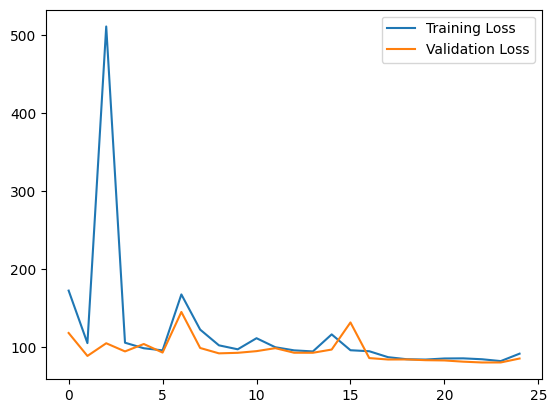

In [0]:
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [0]:
prediction = model_lstm.predict(X_valid_series)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [0]:
print(prediction)

[[ 47.56788 ]
 [113.19783 ]
 [ 44.59197 ]
 ...
 [ 43.86353 ]
 [ 35.6295  ]
 [ 61.895515]]


In [0]:
print(X_valid_series)

[[[ 31.]
  [ 37.]
  [ 45.]
  ...
  [ 28.]
  [ 40.]
  [ 44.]]

 [[116.]
  [120.]
  [121.]
  ...
  [ 94.]
  [ 92.]
  [100.]]

 [[ 35.]
  [ 56.]
  [ 50.]
  ...
  [ 36.]
  [ 40.]
  [ 33.]]

 ...

 [[ 54.]
  [ 71.]
  [ 43.]
  ...
  [ 67.]
  [ 54.]
  [ 62.]]

 [[ 29.]
  [ 30.]
  [ 30.]
  ...
  [ 48.]
  [ 28.]
  [ 27.]]

 [[ 52.]
  [ 54.]
  [ 53.]
  ...
  [ 40.]
  [ 65.]
  [ 40.]]]


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.sql.functions import col, pandas_udf, struct
import pandas as pd

# 1. Define the schema for incoming data
schema = StructType([
    StructField("date", TimestampType(), True),
    StructField("item", StringType(), True),
    StructField("store", StringType(), True),
    StructField("sales", DoubleType(), True)
])

In [0]:
source_path = "/FileStore/shared_uploads/"
stream_df = spark.readStream.schema(schema).csv(source_path)

In [0]:
# 3. Preprocess incoming streaming data (convert to supervised format)
def predict_sales_udf(batch_df, batch_id):
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = batch_df.toPandas()
    pandas_df['date'] = pd.to_datetime(pandas_df['date'])
    
    # Apply the same transformation as in training (series_to_supervised)
    window = 29  # Use the same window size as in training
    lag_size = 1
    supervised_df = series_to_supervised(pandas_df.drop('date', axis=1), window=window, lag=lag_size)
    
    # Keep the relevant rows only
    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    supervised_df = supervised_df[
        (supervised_df['store(t)'] == supervised_df[last_store]) & 
        (supervised_df['item(t)'] == supervised_df[last_item])
    ]
    
    # Drop unnecessary columns
    columns_to_drop = [('%s(t+%d)' % (col, lag_size)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    supervised_df.drop(columns_to_drop, axis=1, inplace=True)
    supervised_df.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    
    # Extract features (X) and reshape for LSTM model
    labels_col = 'sales(t+%d)' % lag_size
    if labels_col in supervised_df:
        supervised_df.drop(labels_col, axis=1, inplace=True)
    X_stream = supervised_df.values.reshape((supervised_df.shape[0], supervised_df.shape[1], 1))
    features = X_stream.tolist()
    predictions = []
    for feature_row in features.values:
        # Reshape input for prediction
        reshaped_feature = feature_row.reshape(1, -1, 1)
        prediction = model_lstm.predict(reshaped_feature, verbose=0)
        predictions.append(prediction[0][0])
    return pd.Series(predictions)

In [0]:
# Apply the preprocessing and prediction steps using foreachBatch
streaming_query = stream_df.writeStream.foreachBatch(predict_sales_udf)

# Save the predictions to a Delta table or output to another sink
output_path = "/FileStore/shared_uploads/output_predictions/"
streaming_query = stream_df.writeStream.format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", "/FileStore/shared_uploads/checkpoints/") \
    .start(output_path)

streaming_query.awaitTermination()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# Correctly read the Delta table
df = spark.read.format("delta").load("/FileStore/shared_uploads/output_predictions/")

# Show the content of the DataFrame
df.show()


+----+----------+-----+-----+
|date|      item|store|sales|
+----+----------+-----+-----+
|NULL|      date|store| NULL|
|NULL|2018-01-01|    1|  1.0|
|NULL|2018-01-02|    1|  1.0|
|NULL|2018-01-03|    1|  1.0|
|NULL|2018-01-04|    1|  1.0|
|NULL|2018-01-05|    1|  1.0|
|NULL|2018-01-06|    1|  1.0|
|NULL|2018-01-07|    1|  1.0|
|NULL|2018-01-08|    1|  1.0|
|NULL|2018-01-09|    1|  1.0|
|NULL|2018-01-10|    1|  1.0|
|NULL|2018-01-11|    1|  1.0|
|NULL|2018-01-12|    1|  1.0|
|NULL|2018-01-13|    1|  1.0|
|NULL|2018-01-14|    1|  1.0|
|NULL|2018-01-15|    1|  1.0|
|NULL|2018-01-16|    1|  1.0|
|NULL|2018-01-17|    1|  1.0|
|NULL|2018-01-18|    1|  1.0|
|NULL|2018-01-19|    1|  1.0|
+----+----------+-----+-----+
only showing top 20 rows

